In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import multivariate_normal
from scipy import stats
from sklearn.mixture import GaussianMixture
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Load ARFF file
data, meta = arff.loadarff('EEG Eye State.arff')

# Convert to Pandas DataFrame
df = pd.DataFrame(data)
df['eyeDetection']=df['eyeDetection'].astype(int)
# Display the DataFrame
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [3]:
X=df[df.columns[:-1]].values
Y=df[df.columns[-1]].values
X=MinMaxScaler().fit_transform(X)

In [4]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.35,random_state=42,stratify=Y)

In [5]:
len(X_train),len(X_test)

(9737, 5243)

In [6]:
X_train.shape

(9737, 14)

In [7]:
def k_means(X, k, max_iters=300, tol=1e-4,kmeanspp=True):
    n_samples, n_features = X.shape
    if kmeanspp:
        centroids = [X[np.random.choice(n_samples)]]
        for _ in range(1, k):
            distances = np.array([min(np.linalg.norm(x - c)**2 for c in centroids) for x in X])
            probabilities = distances / np.sum(distances)
            next_centroid = X[np.random.choice(n_samples, p=probabilities)]
            centroids.append(next_centroid)
        centroids=np.array(centroids)
    else:
        centroids=X[np.random.choice(n_samples,k)]
    for _ in range(max_iters):
        # Assign each data point to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids
    # Post-processing: Re-assign points in small clusters to the nearest centroid
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) < 10: # If a cluster has less than 10 points, re-assign the points
            distances = np.linalg.norm(cluster_points[:, np.newaxis] - centroids, axis=2)
            labels[labels == i] = np.argmin(distances, axis=1)

    # Compute inertia
    inertia = 0.0
    for j in range(k):
        cluster_points = X[labels == j]
        inertia += np.sum(np.linalg.norm(cluster_points - centroids[j], axis=1)**2)

    return centroids, labels,inertia

In [8]:
np.random.seed(42)
data = np.random.random(size=(100,1))
y=np.sin(data*2*np.pi)*np.exp(np.sin(data*2*np.pi))+np.random.random(size=((100,1)))
data=np.hstack((data,y))

Final centroids:
 [[0.24705701 2.82258932]
 [0.71545882 0.19670427]
 [0.17853009 1.26339428]]
Cluster labels:
 [2 1 1 1 0 0 2 1 1 1 1 1 1 0 0 0 0 1 2 0 1 0 0 2 1 1 0 2 1 2 1 0 2 1 1 1 0
 2 1 2 0 1 2 1 0 1 0 1 1 0 1 1 1 1 1 1 2 0 2 0 2 0 1 0 0 1 2 1 2 1 1 0 2 1
 1 1 1 2 0 2 1 1 0 2 0 0 1 1 1 1 2 1 1 1 1 1 1 2 2 2]
Final centroids:
 [[0.24705701 2.82258932]
 [0.71545882 0.19670427]
 [0.17853009 1.26339428]]
Cluster labels:
 [2 1 1 1 0 0 2 1 1 1 1 1 1 0 0 0 0 1 2 0 1 0 0 2 1 1 0 2 1 2 1 0 2 1 1 1 0
 2 1 2 0 1 2 1 0 1 0 1 1 0 1 1 1 1 1 1 2 0 2 0 2 0 1 0 0 1 2 1 2 1 1 0 2 1
 1 1 1 2 0 2 1 1 0 2 0 0 1 1 1 1 2 1 1 1 1 1 1 2 2 2]


/home/abdissad/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


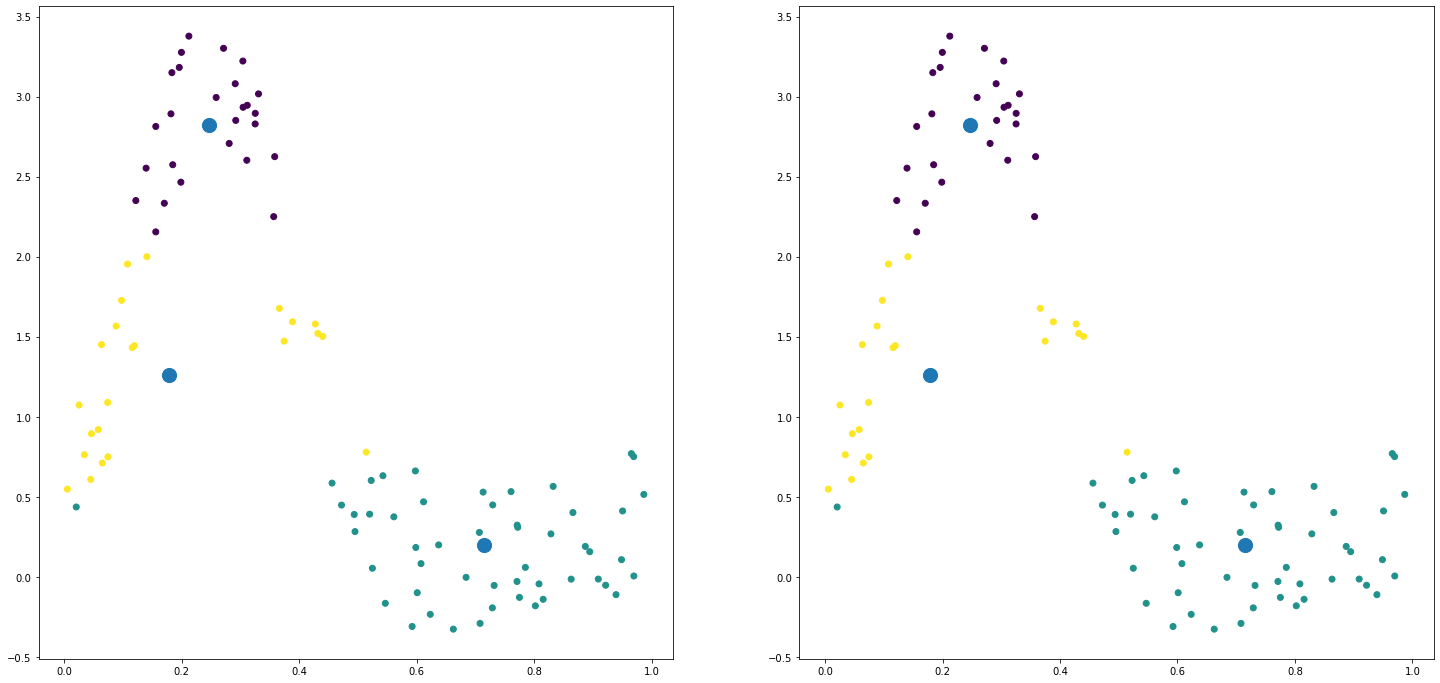

In [9]:
# Specify the number of clusters
num_clusters = 3

# Run k-means algorithm
centroids, labels,inertia = k_means(data, num_clusters)

# Print the final centroids and cluster labels
print("Final centroids:\n", centroids)
print("Cluster labels:\n", labels)
figure,[ax1,ax2]=plt.subplots(1,2,figsize=(25,12))
ax1.scatter(data[:,0],data[:,1],c=labels)
ax1.scatter(centroids[:,0],centroids[:,1],cmap=plt.cm.Blues_r,s=200)
kmeans=KMeans(n_clusters=num_clusters).fit(data)
centroids, labels=kmeans.cluster_centers_,kmeans.labels_
print("Final centroids:\n", centroids)
print("Cluster labels:\n", labels)
ax2.scatter(data[:,0],data[:,1],c=labels,)
ax2.scatter(centroids[:,0],centroids[:,1],cmap=plt.cm.Blues_r,s=200)

In [158]:
k_means(X_train,k=5)

(array([[0.01055191, 0.23524589, 0.55018967, 0.00259644, 0.51208623,
         0.00512907, 0.00350052, 0.01459089, 0.01072301, 0.49484019,
         0.25740824, 0.42347978, 0.02957747, 0.00416419],
        [0.01062197, 0.23561327, 0.55258321, 0.00260484, 0.51411441,
         0.0051557 , 0.00352642, 0.02166948, 0.0107911 , 0.49890628,
         0.26472052, 0.42738971, 0.02975307, 0.00420224],
        [0.01085904, 0.24833052, 0.56509142, 0.00270847, 0.52843519,
         0.00534483, 0.00362808, 0.04118687, 0.01098984, 0.51089805,
         0.28224855, 0.43959008, 0.03018631, 0.00429775],
        [0.        , 1.        , 0.80858692, 0.        , 0.        ,
         0.        , 0.00264627, 1.        , 0.01221493, 1.        ,
         0.53452778, 1.        , 0.        , 0.        ],
        [0.01079628, 0.24745706, 0.55488588, 0.00263999, 0.51425671,
         0.00513975, 0.00351423, 0.01381609, 0.01074052, 0.49678632,
         0.26490186, 0.42889513, 0.02984715, 0.00425621]]),
 array([1, 1, 4, .

In [10]:
KMeans(n_clusters=5,random_state=42).fit(X_train).cluster_centers_

/home/abdissad/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([[0.01062281, 0.23567819, 0.55260479, 0.00260503, 0.51414999,
        0.00515593, 0.00352673, 0.02171322, 0.01079155, 0.49893434,
        0.26479821, 0.42742245, 0.02975455, 0.00420262],
       [0.        , 1.        , 0.80858692, 0.        , 0.        ,
        0.        , 0.00264627, 1.        , 0.01221493, 1.        ,
        0.53452778, 1.        , 0.        , 0.        ],
       [0.01055222, 0.23520498, 0.55019913, 0.00259636, 0.51208309,
        0.00512918, 0.00350067, 0.01464745, 0.01072359, 0.49486866,
        0.25744418, 0.42350474, 0.02957865, 0.00416441],
       [0.0108596 , 0.24832613, 0.5650745 , 0.00270826, 0.52839827,
        0.00534416, 0.00362772, 0.04111364, 0.01098924, 0.51088383,
        0.2822531 , 0.43958931, 0.03018799, 0.00429819],
       [0.01079537, 0.24745595, 0.55488276, 0.00264016, 0.51424096,
        0.00513966, 0.00351369, 0.01372389, 0.01073941, 0.49673995,
        0.26479795, 0.42884703, 0.02984432, 0.00425564]])

4


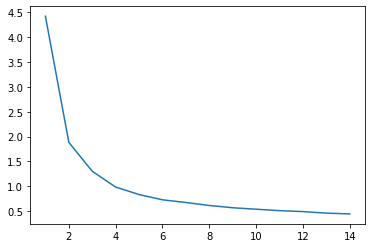

In [11]:
K=int(np.sqrt(X_train.shape[1]).round())
print(K)
K=15
inertia=[]
for k in range(1,K):
    inertia.append(k_means(X_train,k=k)[2])
plt.plot(range(1,K),inertia)

(100, 2)
[139.83316193992445, 29.663432364985248, 14.237038429149678, 9.608792494194766, 7.615567255958244, 4.4215908427120185, 3.8954348023236456, 5.121545709465813, 2.944802013799495]


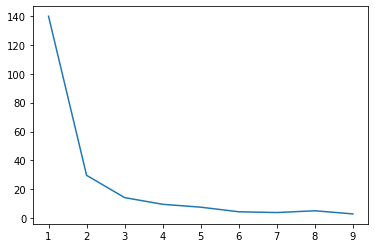

In [161]:
print(data.shape)
K=range(1,int(np.sqrt(data[:,0].shape[0]).round()))
inertia=[]
for k in K:
    inertia.append(k_means(data,k=k)[2])
plt.plot(K,inertia)
print(inertia)

In [12]:

def max_euclidean_distance(array):
        pairwise_distances = cdist(array,array, metric='euclidean')
        np.fill_diagonal(pairwise_distances, 0)  # Set diagonal elements to 0 to exclude self-distances
        max_distance = np.max(pairwise_distances)
        print('exit')
        return max_distance

In [13]:
max_euclidean_distance(np.array([[1,1],[2,2],[4,5]]))

exit


5.0

**Adam Optimizer for Logistic Regression**

In [164]:
class Optimizer_Adam:
    def __init__(self,learning_rate=0.001,decay=0.,epsilon=1e-7,beta_1=0.9,beta_2=0.999):
        self.learning_rate=learning_rate
        self.current_learning_rate=learning_rate
        self.decay=decay
        self.iterations=0
        self.epsilon=epsilon
        self.beta_1=beta_1
        self.beta_2=beta_2
        self.weight_momentums=None
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate=self.learning_rate* \
                        (1./(1.+self.decay*self.iterations))
    def update_params(self,w2,gradient):
        if not hasattr(self,'weight_cache'):
            self.weight_momentums=np.zeros_like(w2)
            self.weight_cache=np.zeros_like(w2)
        self.weight_momentums=self.beta_1* \
                    self.weight_momentums +\
                    (1-self.beta_1)*gradient
        
        weight_momentums_corrected=self.weight_momentums/ \
            (1-self.beta_1**(self.iterations+1))
        
        self.weight_cache=self.beta_2*self.weight_cache+ \
            (1-self.beta_2)*gradient**2
        
        weight_cache_corrected=self.weight_cache/\
            (1-self.beta_2**(self.iterations+1))
        
        w2+= -self.current_learning_rate* \
                        weight_momentums_corrected/ \
                        (np.sqrt(weight_cache_corrected)+self.epsilon)
        return w2
    def post_update_params(self):
        self.iterations+=1

**Radial Basis Layer**

In [36]:
class RadialBasisLayer:
    # X here is the training data
    def __init__(self,X,K=6,initalize_randomly=False,multivariate=False):
        self.X=X
        self.multivariate=multivariate
        num_samples,num_features=self.X.shape
        if initalize_randomly:
            ind=np.random.choice(num_samples,K,replace=False)
            centroids=X[ind]
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            labels = np.argmin(distances, axis=1)
        else:
            centroids,labels,inertia=k_means(self.X,k=K)
        self.w=centroids
        self.labels=labels
        if multivariate:
            GMM=GaussianMixture(n_components=self.w.shape[0],means_init=self.w,tol=1e-4,max_iter=300)
            gm=GMM.fit(self.X)
            self.variance=gm.covariances_
            # self.variance=[]
            # for i in np.unique(self.labels):
            #     data = self.X[self.labels==i]
            #     mean=centroids[i].reshape(1,-1)
            #     covariance = (data-mean).T @ (data-mean)
            #     # covariance+=np.abs(np.random.random(size=covariance.shape)/1000)
            #     # # Compute the minimum eigenvalue of the covariance matrix
            #     # min_eig = np.min(np.real(np.linalg.eigvals(covariance)))

            #     # # If the minimum eigenvalue is negative, add a small multiple of the identity matrix to the covariance matrix
            #     # if min_eig < 0:
            #     #     covariance += 1000 * min_eig * np.eye(covariance.shape[0])
            #     self.variance.append(covariance)
        else:
            self.variance=max_euclidean_distance(self.w)/np.sqrt(2*self.w.shape[0])

    # X here is the input to the layer
    def forward(self,X):
        
        if self.multivariate:
            output=np.zeros(shape=(X.shape[0],len(self.w)))
            i=-1
            for cov,w in zip(self.variance,self.w):
                i+=1
                w=w.reshape(-1,).tolist()
                mvn = multivariate_normal(mean=w, cov=cov,allow_singular=True)

                # Compute the probability density function at a given point
                prob = mvn.pdf(X)
                output[:,i]=prob.reshape(X.shape[0],)
        else:
            # computing distance between the centroids of the hidden layers
            # and the input data
            pairwise_distances = cdist(X,self.w, metric='euclidean')
            # compute the output of the hidden layer
            output=np.exp(-0.5*(pairwise_distances/self.variance)**2)

        output=np.hstack([np.ones(shape=(output.shape[0],1)),output]) # adding vector of ones to add bias weights in the next layer
        return output


**Final Output Layer**

In [15]:
class OutputLayer:
    def __init__(self,X,Y,type='Regression',lr=0.001,epochs=10000):
        self.X=X
        self.Y=Y
        self.lr=lr
        self.epochs=epochs
        self.type=type

        if self.type=='Regression':
            self.w=np.linalg.pinv(self.X) @ self.Y

        if self.type=='Classification':
            # self.w=np.zeros(shape=(self.X.shape[1],1))
            self.w=np.linalg.pinv(self.X) @ np.squeeze(np.eye(2)[self.Y])
            self.w=(self.w[:,1]-self.w[:,0]).reshape(-1,1)
            Adam=Optimizer_Adam(learning_rate=self.lr)
            # Besterror=float('inf')
            # bestWeight=None
            for i in range(self.epochs):
                result = (1/(1+np.exp(-self.X @ self.w))) # using sigmoid
                err = result - self.Y
                Adam.pre_update_params()
                self.w=Adam.update_params(self.w,self.X.T @ err)
                Adam.post_update_params()
                # self.w=self.w-self.lr*(self.X.T @ err)
                self.w=self.w.reshape(-1,1)
            #     error=np.mean(np.abs(err),axis=0)
            #     if error<Besterror:
            #         Besterror=error
            #         bestWeight=self.w
            # self.w=bestWeight

    def forward(self,X):
        if self.type=="Regression":
            output=X @ self.w
            return output
        
        if self.type=="Classification":
            result = ((X @ self.w) >= 0).reshape(1,-1)
            return result.astype(int).tolist()

**Super class to all the RBFN classes**

In [22]:
class RBFN:
    def __init__(self,X,Y,numHiddenLayers=1,type='Regression',epochs=10000,lr=0.0001,multivariate=False):
        self.X=X
        self.Y=Y
        self.type=type
        self.lr=lr
        self.epochs=epochs
        self.multivariate=multivariate
        self.layers=[]
        self.numHiddenLayers=numHiddenLayers
    def forward(self,X):
        output=X
        for i in range(len(self.layers)):
            output=self.layers[i].forward(output)
        return output

**Exact RBFN**

In [27]:
class ExactRBFN(RBFN):
    def __init__(self,X,Y,numHiddenLayers=1,type='Regression',epochs=10000,lr=0.0001,multivariate=False):
        super().__init__(X,Y,numHiddenLayers,type,epochs,lr,multivariate)
        self.K=[self.X.shape[0]]
        output=self.X
        for i in range(self.numHiddenLayers):
            layer=RadialBasisLayer(output,K=self.K[i%self.numHiddenLayers],initalize_randomly=True,multivariate=self.multivariate)
            output=layer.forward(output)
            self.layers.append(layer)
        self.layers.append(OutputLayer(output,self.Y,type=self.type,lr=self.lr,epochs=self.epochs))     

**Random sampling Based RBFN**

In [28]:
class RandomRBFN(RBFN):
    def __init__(self,X,Y,K=[6],numHiddenLayers=1,type='Regression',epochs=10000,lr=0.0001,multivariate=False):
        super().__init__(X,Y,numHiddenLayers,type,epochs,lr,multivariate)
        self.K=K
        output=self.X
        for i in range(self.numHiddenLayers):
            layer=RadialBasisLayer(output,K=self.K[i%self.numHiddenLayers],initalize_randomly=True,multivariate=self.multivariate)
            output=layer.forward(output)
            self.layers.append(layer)
        self.layers.append(OutputLayer(output,self.Y,type=self.type,lr=self.lr,epochs=self.epochs))     

**K means clustering based RBFN**

In [29]:
class ClusterRBFN(RBFN):
    def __init__(self,X,Y,K=[6],numHiddenLayers=1,type='Regression',epochs=10000,lr=0.0001,multivariate=False):
        super().__init__(X,Y,numHiddenLayers,type,epochs,lr,multivariate)
        self.K=K
        output=self.X
        for i in range(self.numHiddenLayers):
            layer=RadialBasisLayer(output,K=self.K[i%self.numHiddenLayers],initalize_randomly=False,multivariate=self.multivariate)
            output=layer.forward(output)
            self.layers.append(layer)
        self.layers.append(OutputLayer(output,self.Y,type=self.type,lr=self.lr,epochs=self.epochs))     

exit
exit


Text(0.5, 1.0, 'Exact RBFN Plot')

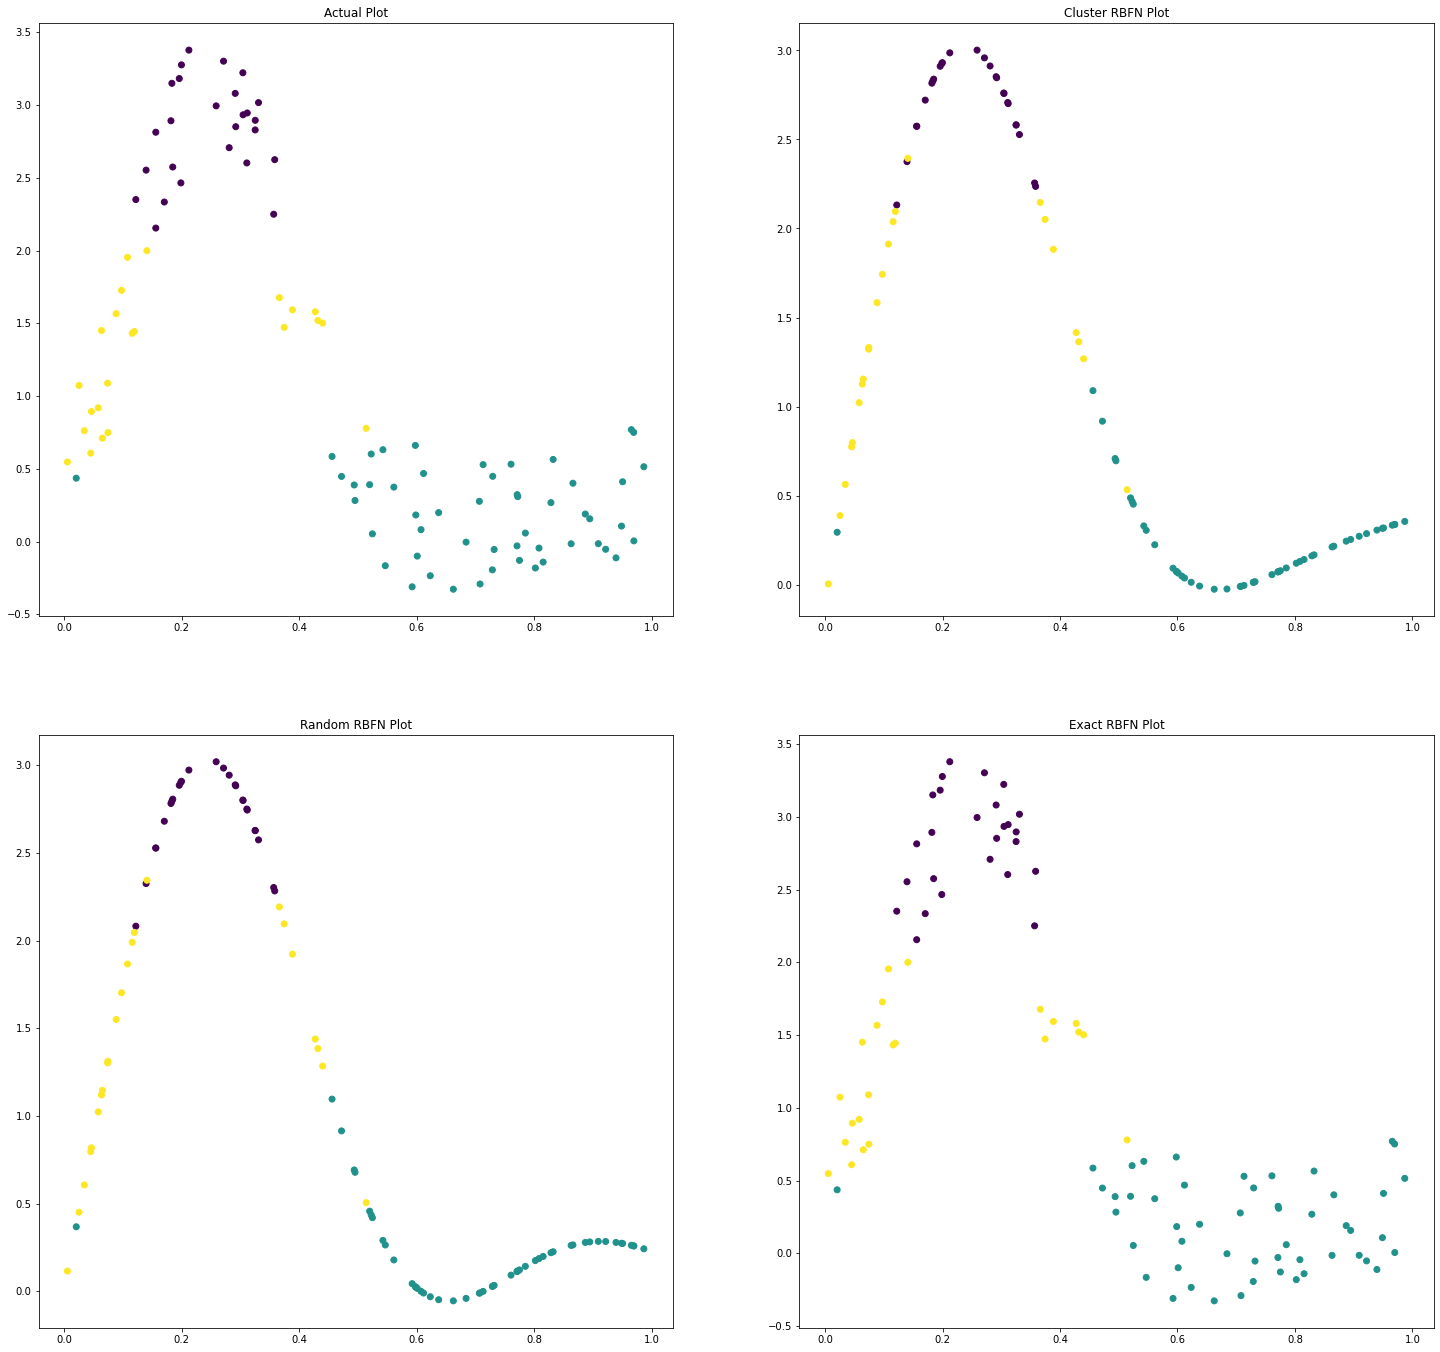

In [37]:
K=[5]
clusterrbfn=ClusterRBFN(X=data[:,0].reshape(-1,1),Y=data[:,1].reshape(-1,1),K=K,type='Regression')
predictionCluster=clusterrbfn.forward(data[:,0].reshape(-1,1))
randomrbfn=RandomRBFN(X=data[:,0].reshape(-1,1),Y=data[:,1].reshape(-1,1),K=K)
predictionRandom=randomrbfn.forward(data[:,0].reshape(-1,1))
exact_rbfn=ExactRBFN(X=data[:,0].reshape(-1,1),Y=data[:,1].reshape(-1,1),multivariate=True)
predictionExact=exact_rbfn.forward(data[:,0].reshape(-1,1))
figure,[[ax1,ax2],[ax3,ax4]]=plt.subplots(2,2,figsize=(25,24))
ax1.scatter(data[:,0],data[:,1],c=labels)
ax1.set_title("Actual Plot")
ax2.scatter(data[:,0],predictionCluster,c=labels)
ax2.set_title("Cluster RBFN Plot")
ax3.scatter(data[:,0],predictionRandom,c=labels)
ax3.set_title("Random RBFN Plot")
ax4.scatter(data[:,0],predictionExact,c=labels)
ax4.set_title("Exact RBFN Plot")

In [172]:
accuracy=[]
K=range(10,50,10)
for k in K:
    clusterrbfn=ClusterRBFN(X=X_train,Y=Y_train.reshape(-1,1),K=[k],epochs=1000,lr=0.0001,type='Classification')
    pred=clusterrbfn.forward(X_test)
    accuracy.append(np.mean(pred==Y_test))
    print(f'Test Accuracy with K value-{k}: ',np.mean(pred==Y_test))

exit
Test Accuracy with K value-10:  0.5807743658210948
exit
Test Accuracy with K value-20:  0.5893572382223917
exit
Test Accuracy with K value-30:  0.6540148769788289
exit
Test Accuracy with K value-40:  0.6702269692923899


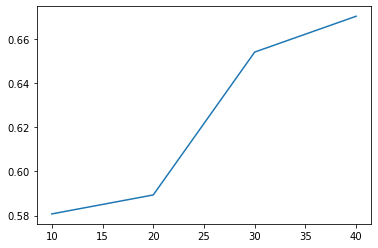

In [173]:
plt.plot(K,accuracy)

In [174]:
np.mean(np.random.randint(0,2,len(Y_test)).reshape(-1,1)==Y_test)

0.5006544242399946

In [175]:
from sklearn.datasets import load_breast_cancer
dataB=load_breast_cancer()
x=dataB['data']
x=MinMaxScaler().fit_transform(x)
y=dataB['target']
print(x.shape,y.shape)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.35,stratify=y,random_state=42)

(569, 30) (569,)


30


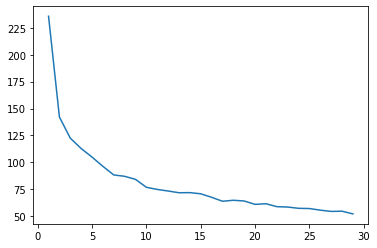

In [176]:
K=int(x_train.shape[1])
print(K)
inertia=[]
for k in range(1,K):
    inertia.append(k_means(x_train,k=k)[2])
plt.plot(range(1,K),inertia)

exit
Test Accuracy with K value-1:  0.625
exit


/tmp/ipykernel_5197/2710421689.py:55: RuntimeWarning: divide by zero encountered in divide
  output=np.exp(-0.5*(pairwise_distances/self.variance)**2)


Test Accuracy with K value-2:  0.915
exit
Test Accuracy with K value-3:  0.915
exit
Test Accuracy with K value-4:  0.915
exit
Test Accuracy with K value-5:  0.915
exit
Test Accuracy with K value-6:  0.95
exit
Test Accuracy with K value-7:  0.94
exit
Test Accuracy with K value-8:  0.965
exit
Test Accuracy with K value-9:  0.945
exit
Test Accuracy with K value-10:  0.94
exit
Test Accuracy with K value-11:  0.95
exit
Test Accuracy with K value-12:  0.935
exit
Test Accuracy with K value-13:  0.95
exit
Test Accuracy with K value-14:  0.955
exit
Test Accuracy with K value-15:  0.94
exit
Test Accuracy with K value-16:  0.96
exit
Test Accuracy with K value-17:  0.925
exit
Test Accuracy with K value-18:  0.965
exit
Test Accuracy with K value-19:  0.96
exit
Test Accuracy with K value-20:  0.925
exit
Test Accuracy with K value-21:  0.93
exit
Test Accuracy with K value-22:  0.97
exit
Test Accuracy with K value-23:  0.925
exit
Test Accuracy with K value-24:  0.955
exit
Test Accuracy with K value-25

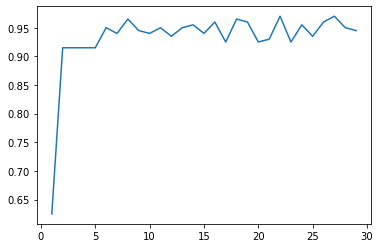

In [177]:
accuracy=[]
K=range(1,30)
for k in K:
    clusterrbfn=ClusterRBFN(X=x_train,Y=y_train.reshape(-1,1),K=[k],epochs=1000,lr=0.0001,type='Classification')
    pred=clusterrbfn.forward(x_test)
    accuracy.append(np.mean(pred==y_test))
    print(f'Test Accuracy with K value-{k}: ',np.mean(pred==y_test))
plt.plot(K,accuracy)

In [178]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# Load the EEG eye state dataset
# This is just a placeholder. You would replace this with your actual dataset

# Define the RBF kernel
kernel = 1.0 * RBF(1.0)

# Define the Gaussian process classifier
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0)

# Fit the classifier to the data
gpc.fit(x_train, y_train)

# Score the classifier
score = gpc.score(x_test, y_test)
print("Score: ", score)

# Predict the class probabilities for the first two samples
proba = gpc.predict_proba(x_test)
print("Probabilities: ", proba)


Score:  0.985
Probabilities:  [[5.05798981e-04 9.99494201e-01]
 [8.91171319e-01 1.08828681e-01]
 [1.04690890e-01 8.95309110e-01]
 [3.76147722e-02 9.62385228e-01]
 [2.75990440e-03 9.97240096e-01]
 [9.00494482e-01 9.95055185e-02]
 [1.34586560e-01 8.65413440e-01]
 [9.94947259e-01 5.05274136e-03]
 [4.66289835e-01 5.33710165e-01]
 [7.58037856e-01 2.41962144e-01]
 [1.91034254e-03 9.98089657e-01]
 [2.48278863e-01 7.51721137e-01]
 [1.50414857e-01 8.49585143e-01]
 [1.07057140e-02 9.89294286e-01]
 [2.17141472e-01 7.82858528e-01]
 [9.91030849e-01 8.96915149e-03]
 [1.71692140e-03 9.98283079e-01]
 [3.30833259e-03 9.96691667e-01]
 [1.59395824e-03 9.98406042e-01]
 [9.61329567e-01 3.86704327e-02]
 [3.02143055e-01 6.97856945e-01]
 [2.96865872e-01 7.03134128e-01]
 [9.45905930e-01 5.40940701e-02]
 [2.75889001e-02 9.72411100e-01]
 [9.43158778e-01 5.68412220e-02]
 [9.95906814e-01 4.09318571e-03]
 [8.71111938e-03 9.91288881e-01]
 [9.98959732e-01 1.04026818e-03]
 [9.98637401e-01 1.36259944e-03]
 [9.49319412e

In [179]:
K=[9]
clusterrbfn=ClusterRBFN(X=x_train,Y=y_train.reshape(-1,1),K=K,numHiddenLayers=1,epochs=1000,lr=0.0001,type='Classification')
y_pred=clusterrbfn.forward(x_test)
print(y_pred)
print(y_test)
print(f'Test Accuracy with K value-{K}: ',np.mean(y_pred==y_test))


exit
[[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]]
[1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 0
 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1
 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 1 1
 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0
 0 1 1 0 0 0 1 1 

In [180]:
K=[90]
clusterrbfn=ClusterRBFN(X=X_train,Y=Y_train.reshape(-1,1),K=K,numHiddenLayers=1,epochs=1000,lr=0.0001,type='Classification')
y_pred=clusterrbfn.forward(X_test)
# print(pred)
# print(Y_test)
print(f'Test Accuracy with K value-{K}: ',np.mean(y_pred==Y_test))

exit
Test Accuracy with K value-[90]:  0.6959755864962808


In [188]:
# Two hidden layers with covariance from the cluster
K=[30,2]
clusterrbfn=ClusterRBFN(X=X_train,Y=Y_train.reshape(-1,1),K=K,numHiddenLayers=2,epochs=1000,lr=0.0001,type='Classification',multivariate=True)
y_pred=clusterrbfn.forward(X_test)
# print(pred)
# print(Y_test)
print(f'Test Accuracy with K value-{K}: ',np.mean(y_pred==Y_test))

Test Accuracy with K value-[30, 2]:  0.5512111386610719


In [189]:
# Two hidden layers with multivariate covariance
K=[50,2]
clusterrbfn=ClusterRBFN(X=X_train,Y=Y_train.reshape(-1,1),K=K,numHiddenLayers=2,epochs=1000,lr=0.0001,type='Classification',multivariate=False)
y_pred=clusterrbfn.forward(X_test)
# print(pred)
# print(Y_test)
print(f'Test Accuracy with K value-{K}: ',np.mean(y_pred==Y_test))

exit
exit
Test Accuracy with K value-[50, 2]:  0.5573145145908831


In [181]:
LR=LogisticRegression()
LR.fit(X_train,Y_train)
y_pred=LR.predict(X_test)
print("Accuracy: ",accuracy_score(Y_test,y_pred))
# Print classification report
print(classification_report(Y_test, y_pred))

Accuracy:  0.5512111386610719
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      2890
           1       0.50      0.00      0.00      2353

    accuracy                           0.55      5243
   macro avg       0.53      0.50      0.36      5243
weighted avg       0.53      0.55      0.39      5243



In [182]:
clf = svm.SVC(kernel='rbf', gamma='scale')

# Train the classifier
clf.fit(X_train, Y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)
print("Accuracy: ",accuracy_score(Y_test,y_pred))
# Print classification report
print(classification_report(Y_test, y_pred))

Accuracy:  0.5512111386610719
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      2890
           1       0.00      0.00      0.00      2353

    accuracy                           0.55      5243
   macro avg       0.28      0.50      0.36      5243
weighted avg       0.30      0.55      0.39      5243



/home/abdissad/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abdissad/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abdissad/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [183]:
# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier on the training data
nb_classifier.fit(X_train, Y_train)

# Make predictions on the test data
y_pred = nb_classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(Y_test, y_pred))

Accuracy: 0.48
              precision    recall  f1-score   support

           0       0.60      0.15      0.24      2890
           1       0.46      0.88      0.60      2353

    accuracy                           0.48      5243
   macro avg       0.53      0.51      0.42      5243
weighted avg       0.53      0.48      0.40      5243



In [184]:
# K=[250]
# clusterrbfn=ClusterRBFN(X=X_train,Y=Y_train.reshape(-1,1),K=K,numHiddenLayers=1,epochs=5000,lr=0.001,type='Classification')
# pred=clusterrbfn.forward(X_test)
# # print(pred)
# # print(Y_test)
# print(f'Test Accuracy with K value-{K}: ',np.mean(pred==Y_test))

In [185]:
# np.save('w13.npy',clusterrbfn.layers[0].w)
# np.save('w23.npy',clusterrbfn.layers[1].w)